#### Environment setup

In [1]:
!pip install "numpy<1.24"
!pip install scikit-learn scikit-multiflow
!pip install seaborn

  Using cached numpy-1.23.5-cp38-cp38-win_amd64.whl (14.7 MB)
  Using cached scikit_learn-1.2.2-cp38-cp38-win_amd64.whl (8.3 MB)
  Using cached scikit_multiflow-0.5.3-cp38-cp38-win_amd64.whl (539 kB)
                                              0.0/42.2 MB ? eta -:--:--
                                              0.1/42.2 MB 3.3 MB/s eta 0:00:13
                                              0.3/42.2 MB 2.6 MB/s eta 0:00:17
                                              0.4/42.2 MB 2.9 MB/s eta 0:00:15
                                              0.6/42.2 MB 3.0 MB/s eta 0:00:15
                                              0.7/42.2 MB 3.2 MB/s eta 0:00:14
                                              0.8/42.2 MB 3.1 MB/s eta 0:00:14
                                              1.0/42.2 MB 3.1 MB/s eta 0:00:14
     -                                        1.1/42.2 MB 3.0 MB/s eta 0:00:14
     -                                        1.3/42.2 MB 3.0 MB/s eta 0:00:14
     -           

#### SEA Generator Stream Analysis

In [5]:
from skmultiflow.data.sea_generator import SEAGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import metrics

sea_stream = SEAGenerator(classification_function = 2, random_state = 112)
sea_stream.get_data_info()

'SEA Generator - 1 target(s), 2 classes, 3 features'

In [6]:
df = pd.DataFrame()
N_SAMPLES = 10000
curr_samples = 0
features = [[], [], []]
targets = []


while curr_samples < N_SAMPLES:
    X, y = sea_stream.next_sample()

    features[0].append(X[0][0])
    features[1].append(X[0][1])
    features[2].append(X[0][2])
    targets.append(y[0])

    curr_samples += 1

df = pd.DataFrame({'Feature 1': features[0], 'Feature 2': features[1], 'Feature 3': features[2], 'Target': targets})
df.head()

,Feature 1,Feature 2,Feature 3,Target
0,3.750571,6.403046,9.500166,1
1,7.769297,8.327458,0.548057,1
2,8.853515,7.223465,0.025560,1
3,3.434199,0.947599,3.946426,0
4,7.367068,9.558069,8.206094,1


In [7]:
df.dtypes

Feature 1    float64
Feature 2    float64
Feature 3    float64
Target         int64
dtype: object

In [8]:
df.describe(include='all')

,Feature 1,Feature 2,Feature 3,Target
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.963432,4.994533,5.079517,0.750900
std,2.867441,2.866729,2.894436,0.432513
min,0.001500,0.001308,0.000956,0.000000
25%,2.475681,2.528634,2.567246,1.000000
50%,4.932272,4.997411,5.129783,1.000000
75%,7.414149,7.444826,7.589916,1.000000
max,9.998576,9.996548,9.999960,1.000000


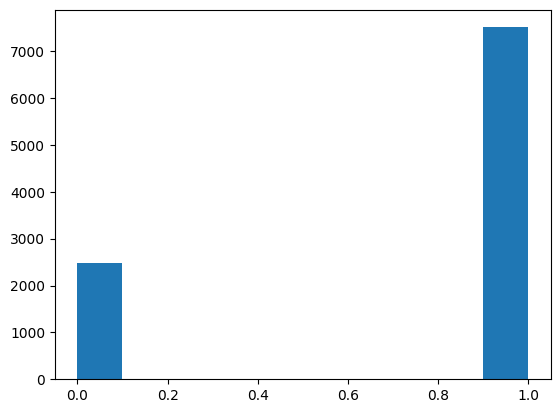

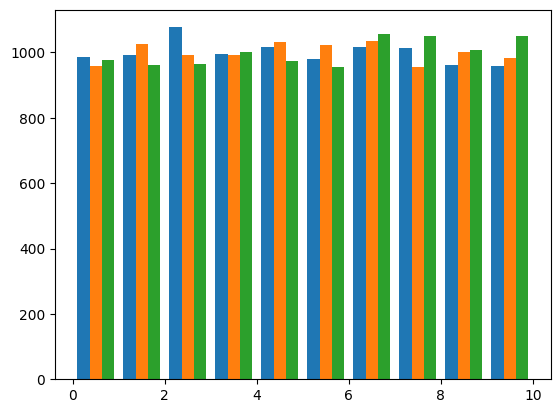

In [9]:
plt.hist(df['Target'])
plt.show()

plt.hist(df.drop('Target', axis=1))
plt.show()


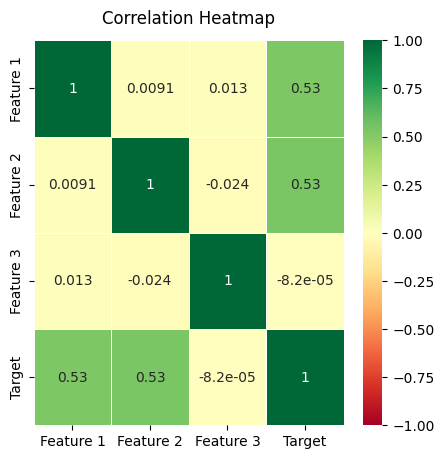

In [10]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
#plot heat map

g=sns.heatmap(df[top_corr_features].corr(), vmin=-1, vmax=1, annot=True,cmap="RdYlGn", linewidth=0.5)
g.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('output.png', dpi=300, bbox_inches='tight')

In [39]:
sea_stream.reset()

#### SEA Generator Drift Analysis

Change has been detected in data: 88 - of index: 88
Warning zone has been detected in data: 299 - of index: 299
Warning zone has ended in data: 303 - of index: 303
Warning zone has been detected in data: 309 - of index: 309
Warning zone has ended in data: 311 - of index: 311
Change has been detected in data: 311 - of index: 311
Change has been detected in data: 359 - of index: 359
Warning zone has been detected in data: 10682 - of index: 10682
Warning zone has ended in data: 10686 - of index: 10686
Warning zone has been detected in data: 10688 - of index: 10688
Warning zone has ended in data: 10845 - of index: 10845
Change has been detected in data: 10845 - of index: 10845
Change has been detected in data: 11091 - of index: 11091
Warning zone has been detected in data: 11182 - of index: 11182
Warning zone has ended in data: 11185 - of index: 11185
Warning zone has been detected in data: 11194 - of index: 11194
Warning zone has ended in data: 11199 - of index: 11199
Warning zone has bee

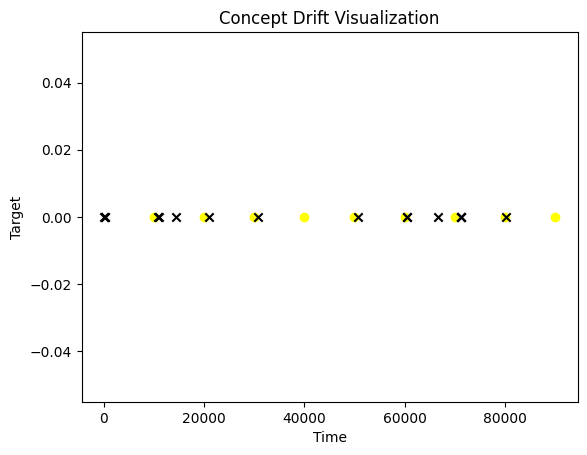

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     36346
           1       0.93      0.98      0.96     63654

    accuracy                           0.95    100000
   macro avg       0.95      0.93      0.94    100000
weighted avg       0.95      0.95      0.94    100000



In [40]:
from skmultiflow.drift_detection import DDM, ADWIN
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.data import HyperplaneGenerator
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report


# stream = HyperplaneGenerator()


drift_detector = DDM(warning_level=2.8) 
clf = GaussianNB()

N_SAMPLES = 100000
curr_samples = 0
actual_drift_points = [n * 10000 for n in range(1, 10)]
guessed_predictions = []
drift_points = []
features = [[], [], []]
targets = []
last_X_window = []
last_y_window = []

X, y = sea_stream.next_sample(25000)
clf.partial_fit(X, y, classes=[0, 1])
in_warning_zone = False

while curr_samples < N_SAMPLES and sea_stream.has_more_samples():
    if curr_samples in actual_drift_points:
        sea_stream.generate_drift()

    X, y = sea_stream.next_sample()

    prediction = clf.predict(X)

    guessed_predictions.append(prediction[0])

    features[0].append(X[0][0])
    features[1].append(X[0][1])
    features[2].append(X[0][2])
    targets.append(y[0])
    drift_detected = drift_detector.add_element(1 - int(y[0] == prediction[0]))
    if not in_warning_zone and drift_detector.detected_warning_zone():
        print('Warning zone has been detected in data: ' + str(curr_samples) + ' - of index: ' + str(curr_samples))
        in_warning_zone = True
    elif in_warning_zone and not drift_detector.detected_warning_zone():
        print('Warning zone has ended in data: ' + str(curr_samples) + ' - of index: ' + str(curr_samples))
        in_warning_zone = False
    if drift_detector.detected_change():
        print('Change has been detected in data: ' + str(curr_samples) + ' - of index: ' + str(curr_samples))
        #drift_detector.reset_change()
        clf = GaussianNB()
        clf.partial_fit(np.array(last_X_window).reshape(-1, 3), np.array(last_y_window).reshape(len(last_y_window)), classes=[0, 1])
        
        drift_points.append(curr_samples)

    clf.partial_fit(X, y)

    if len(last_X_window) > 1000:
        last_X_window.pop(0)
        last_y_window.pop(0)
    last_X_window.append(X)
    last_y_window.append(y)
    
    curr_samples += 1

df = pd.DataFrame({'Feature 1': features[0], 'Feature 2': features[1], 'Feature 3': features[2], 'Target': targets})
df.head()

plt.scatter(actual_drift_points, [0 for i in actual_drift_points], color='yellow', marker='o')
plt.scatter(drift_points, [0 for i in drift_points], color='black', marker='x')
plt.xlabel('Time')
plt.ylabel('Target')
plt.title('Concept Drift Visualization')
plt.show()

print(classification_report(targets, guessed_predictions, target_names=['0', '1']))

In [ ]:

from streams import *
from skmultiflow.data import ConceptDriftStream
from skmultiflow.data import HyperplaneGenerator
from skmultiflow.data import LEDGeneratorDrift

stream = build_data_stream('covtype')


#### Create the ensemble

In [4]:
from ensemble import build_premade_ensemble, build_custom_ensemble
from sklearn.naive_bayes import GaussianNB

ensemble = build_premade_ensemble('batch', 10, GaussianNB())

#### Utilize drift detection methods

#### Evaluate

In [1]:
from skmultiflow.evaluation import EvaluatePrequential

evaluator = EvaluatePrequential(
    n_wait = 10,
    max_samples = 100,
    show_plot = False,
    metrics=['accuracy', 'running_time', 'accuracy', 'precision', 'gmean'],
    data_points_for_classification=False
)

evaluator.evaluate(stream=sea_stream, model=[ensemble], model_names=['ensemble'])

NameError: name 'sea_stream' is not defined